In [7]:
# Import numpy and matplotlib
from collections import namedtuple
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import simps

# Modify the style of the plots
plt.style.use('seaborn-whitegrid')

# Convergence plots for Case 1

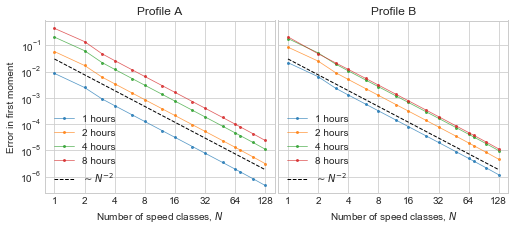

In [15]:
# Total integration time
Tmax = 120*3600
# Max depth of simulation domain
Zmax = 50

# Numerical parameters for reference solution
dt_ref = 10    # Timestep
NJ_ref = 4000  # Number of spatial grid cells
NK_ref = 512   # Number of classes

# Varying numerical parameters
dts = np.array([60, 120, 300])
NJs = np.array([2000])
NKs = np.array([1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 72, 96, 128])

# Hours after which to plot the solutions
hours = [1, 2, 4, 8]

fig, ax = plt.subplots(ncols = 2, figsize = (7, 3), sharex = True, sharey = True)
for iplot, profile in enumerate(['A', 'B']):
    
    #### Reference solution  ####
    # Load data, and work out grid parameters
    Cg_ref = np.load(f'../../data/Case1_K_{profile}_block_Nclasses={NK_ref}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)
    # Concentration grid cell faces (in z-direction)
    Nz_grid_ref, Nt_grid_ref = Cg_ref.shape
    zc_grid_ref  = np.linspace(0, Zmax, Nz_grid_ref + 1)
    # Concentration grid cell spacing
    dz_grid_ref  = zc_grid_ref[1] - zc_grid_ref[0]
    # Concentration grid cell midpoints
    mid_grid_ref = zc_grid_ref[:-1] + dz_grid_ref/2
        
    errors = [np.zeros(len(NKs)) for h in hours]
    for i, n in enumerate(NKs):

        Cg = np.load(f'../../data/Case1_K_{profile}_block_Nclasses={n}_NJ={NJ_ref}_dt={dt_ref}.npy').sum(axis = 2)

        # Concentration grid cells (in z-direction)
        Nz_grid, Nt_grid = Cg.shape
        zc_grid = np.linspace(0, Zmax, Nz_grid + 1)
        dz_grid = zc_grid[1] - zc_grid[0]
        mid_grid = zc_grid[:-1] + dz_grid/2

        for j, h in enumerate(hours):
            ref    = dz_grid_ref * np.sum(mid_grid_ref * Cg_ref[:,6*h])
            moment = dz_grid     * np.sum(mid_grid     * Cg[:,6*h])
            errors[j][i] = np.abs(moment - ref)

    for j, h in enumerate(hours):
        ax[iplot].plot(NKs, errors[j][:], marker = '.', markersize = 4, lw = 0.75, alpha = 0.75, label = f'{h} hours')

    ax[iplot].plot(NKs, 0.03*NKs**(-2.0), '--', c = 'k', lw = 1, label = '$\sim N^{-2}$')


    ax[iplot].legend(loc = 'lower left')
    ax[iplot].set_xscale('log')
    ax[iplot].set_yscale('log')

    ticks = [1, 2, 4, 8, 16, 32, 64, 128]
    ax[iplot].set_xticks(ticks)
    ax[iplot].set_xticklabels(ticks)
    ax[iplot].set_xlim(0.8*1, ticks[-1]/0.8)
    ax[iplot].set_title(f'Profile {profile}')

    
ax[0].set_xlabel('Number of speed classes, $N$')
ax[1].set_xlabel('Number of speed classes, $N$')
ax[0].set_ylabel('Error in first moment')

plt.subplots_adjust(left = 0.075, bottom = 0.12, right = 0.995, top = 0.92, wspace =0.015)
plt.savefig('convergence_Nclasses_case1.pdf')
